In [1]:
import os
import re
import glob
import datetime
import time
import numpy as np
import GPX_functions
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from geopy.distance import great_circle
import hikinggc
import cartopy
import cartopy.crs as ccrs
import contextily as ctx
import configparser
import logging
import geopandas
from pyproj import Proj, transform
from importlib import reload
reload(hikinggc)
plt.style.use('dark_background')

In [9]:
from matplotlib.font_manager import FontProperties
fa_dir = r"/home/ctroupin/Downloads/fontawesome-free-5.0.13/use-on-desktop/"
fp1 = FontProperties(fname=os.path.join(fa_dir, "Font Awesome 5 Free-Solid-900.otf"))
fontfile = "/home/ctroupin/.fonts/D-DIN.ttf"
myfont = FontProperties(fname=fontfile)

In [10]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("Starting")

INFO:root:Starting


## Files and directories

In [11]:
figdir = "../images/"
datafilelist = sorted(glob.glob(os.path.join("/data/GPX/Moves/gpx/Verviers/", "*Running.gpx")))
len(datafilelist)

60

## 1 Simple plot
### Read all coordinates

In [16]:
def read_all_coords(datafilelist, origin=(50.58870, 5.86984), dmax=10.):
    lon_all, lat_all, ele_all = np.array([]), np.array([]), np.array([])
    for datafile in datafilelist:
        lon, lat, ele, t = GPX_functions.read_gpx(datafile)
        d = great_circle((origin[0], (origin[1])), 
                         (np.array(lat).mean(), np.array(lon).mean())).km

        if d < dmax:

            lon_all = np.append(lon_all, lon)
            lat_all = np.append(lat_all, lat)
            ele_all = np.append(ele_all, ele)
            
    return lon_all, lat_all, ele_all

In [17]:
verviers = (50.58870, 5.86984)
lonrun, latrun, elerun = read_all_coords(datafilelist, verviers, 10.)

In [39]:
great_circle((50.58882106911517, 5.869726946529617), (np.mean(latrun), np.mean(lonrun))).km

0.530420343554551

In [38]:
great_circle?

NameError: name 'lon_all' is not defined

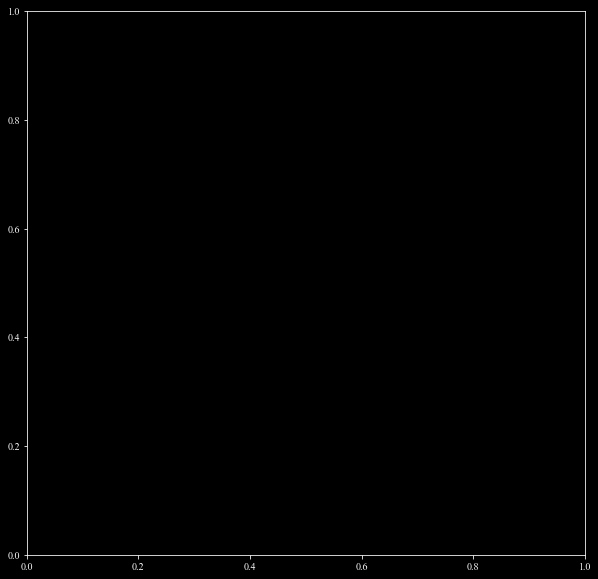

In [14]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
plt.plot(lon_all, lat_all, "o", ms=.05, color="#FFDB61", markerfacecolor="#FFDB61")
plt.ylim(50.54, 50.625)
plt.xlim(5.8, 5.95)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig(os.path.join(figdir, "verviers2020_3.png"), dpi=300, bbox_inches="tight")
plt.show()

## 2. Hexbin plot

In [ ]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
plt.hexbin(lonrun, latrun, gridsize=70, cmap=plt.cm.RdYlBu_r, mincnt=10, vmax=250)
#plt.colorbar()
plt.ylim(50.54, 50.625)
plt.xlim(5.8, 5.95)
ax.set_xticks([])
ax.set_yticks([])
#plt.savefig(os.path.join(figdir, "verviers2020_4.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

## 3. With basemap

In [ ]:
config = configparser.ConfigParser()
config.read("/etc/config.txt")
apikey = config.get("configuration", "thunderkey")
basemap = ctx.providers.Thunderforest.OpenCycleMap
basemap["url"] = "https://{s}.tile.thunderforest.com/outdoors/{z}/{x}/{y}.png?apikey=%s" %(apikey)

In [19]:
basemap = ctx.providers.Esri.WorldTopoMap
basemap["url"]

'https://server.arcgisonline.com/ArcGIS/rest/services/{variant}/MapServer/tile/{z}/{y}/{x}'

INFO:root:Saving map as verviers2020_5e.png


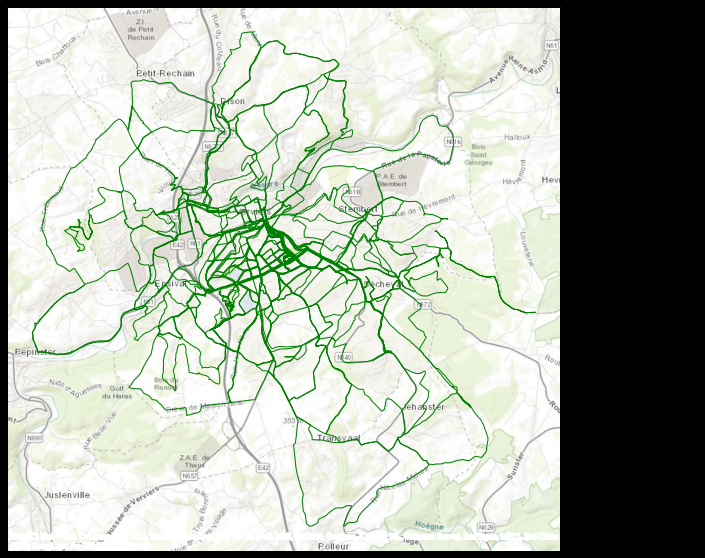

In [10]:
fig = plt.figure(figsize=(10, 10))
proj = ccrs.epsg(3857)
ax = plt.axes(projection=proj)

for gpxfile in datafilelist:
    track = hikinggc.Track()
    track.get_coords(gpxfile)
    
    
    # Compute distance with respect to Verviers
    d = great_circle((verviers[0], (verviers[1])), 
                     (np.array(track.lat).mean(), np.array(track.lon).mean())).km

    
    if d < 10:
        track.add_track_plain(ax, color="#008000")
    
if basemap is not None:
    ctx.add_basemap(ax, source=basemap, origin='upper', zoom=13)

ax.set_xticks([])
ax.set_yticks([])

figname = "verviers2020_5e.png"
logger.info("Saving map as {}".format(figname))
plt.savefig(os.path.join(figdir, figname), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

## 4. Hexbin + basemap

In [22]:
plt.hexbin?

<ipython-input-31-6aafdf8d5268>:7: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xxt, yyt = transform(inproj, outproj, latrun, lonrun)


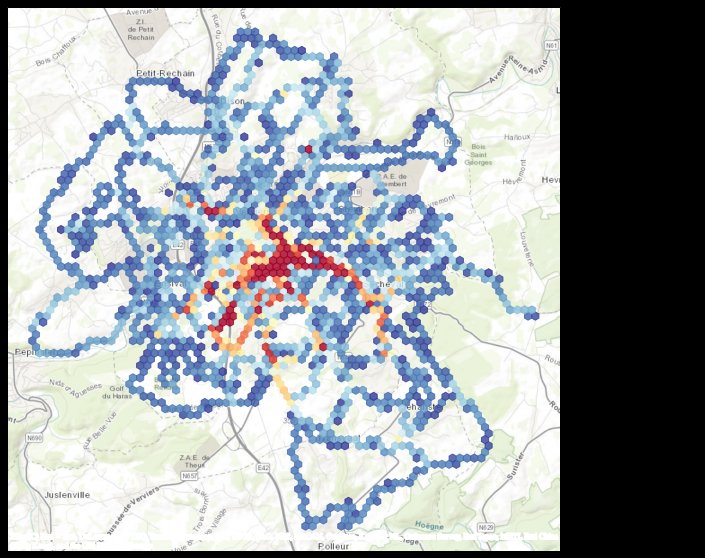

In [31]:
fig = plt.figure(figsize=(10, 10))
proj = ccrs.epsg(3857)
ax = plt.axes(projection=proj)

outproj = 'epsg:3857'
inproj = 'epsg:4326'
xxt, yyt = transform(inproj, outproj, latrun, lonrun)
ax.hexbin(xxt, yyt, gridsize=70, reduce_C_function=np.log, 
          cmap=plt.cm.RdYlBu_r, mincnt=1, vmax=300, alpha=.8)

if basemap is not None:
    ctx.add_basemap(ax, source=basemap, origin='upper', zoom=13)

ax.set_xticks([])
ax.set_yticks([])

plt.savefig(os.path.join(figdir, "verviers2020_6e.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

## 5. Adding municipality limits
Converted from shapefile to geoJSON with `QGIS`.

In [32]:
df = geopandas.read_file("../data/verviers2020.geojson")
df = df.to_crs(epsg=3857)
xverviers, yverviers = df['geometry'].exterior[0].xy

In [ ]:
fig = plt.figure(figsize=(10, 10))
proj = ccrs.epsg(3857)
ax = plt.axes(projection=proj)

ax.fill(xverviers, yverviers, edgecolor="k", color="g", linewidth=2, alpha=.15)

outproj = 'epsg:3857'
inproj = 'epsg:4326'
xxt, yyt = transform(inproj, outproj, latrun, lonrun)

ax.hexbin(xxt, yyt, gridsize=70, reduce_C_function=np.log, 
          cmap=plt.cm.RdYlBu_r, mincnt=1, vmax=300, alpha=.8)

if basemap is not None:
    ctx.add_basemap(ax, source=basemap, origin='upper', zoom=13)

ax.set_xticks([])
ax.set_yticks([])

plt.savefig(os.path.join(figdir, "verviers2020_7.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

<ipython-input-33-238e791971b5>:9: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xxt, yyt = transform(inproj, outproj, latrun, lonrun)


## 6. Hiking tracks

In [25]:
datafilelist2 = sorted(glob.glob(os.path.join("/data/GPX/Moves/gpx/Verviers/", "*Trekking.gpx")))
lonhike, lathike, elehile = read_all_coords(datafilelist2, verviers, 10.)
len(datafilelist2)

125

In [54]:
basemap2 = ctx.providers.CartoDB.Voyager

<ipython-input-56-825aa1084c60>:9: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xxt, yyt = transform(inproj, outproj, lathike, lonhike)


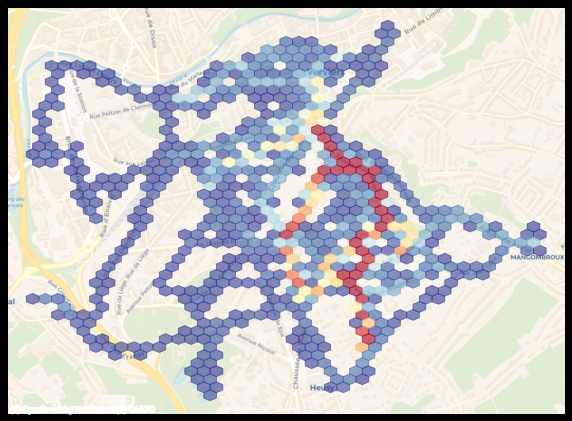

In [56]:
fig = plt.figure(figsize=(10, 10))
proj = ccrs.epsg(3857)
ax = plt.axes(projection=proj)

#ax.fill(xverviers, yverviers, edgecolor="k", color="g", linewidth=2, alpha=.15)

outproj = 'epsg:3857'
inproj = 'epsg:4326'
xxt, yyt = transform(inproj, outproj, lathike, lonhike)
plt.hexbin(xxt, yyt, gridsize=40, cmap=plt.cm.RdYlBu_r, mincnt=1, vmax=1000, alpha=.6)

if basemap is not None:
    ctx.add_basemap(ax, source=basemap2, origin='upper', zoom=15)

ax.set_xticks([])
ax.set_yticks([])

plt.savefig(os.path.join(figdir, "verviers2020_8.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

<ipython-input-59-9599e4627ff1>:9: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xxt, yyt = transform(inproj, outproj, latrun, lonrun)


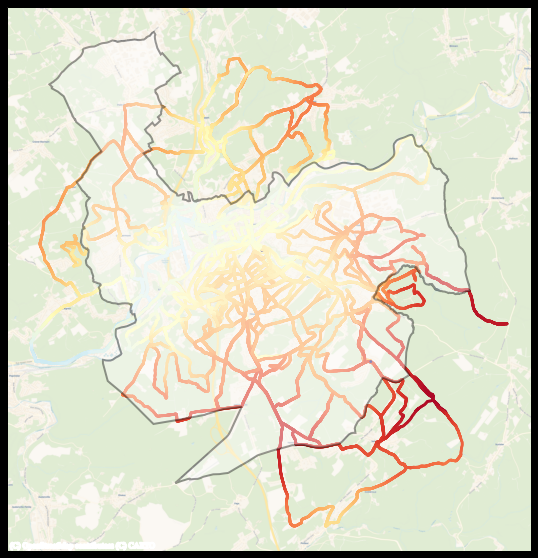

In [59]:
fig = plt.figure(figsize=(10, 10))
proj = ccrs.epsg(3857)
ax = plt.axes(projection=proj)

ax.fill(xverviers, yverviers, edgecolor="k", color="w", linewidth=2, alpha=.4)

outproj = 'epsg:3857'
inproj = 'epsg:4326'
xxt, yyt = transform(inproj, outproj, latrun, lonrun)
plt.scatter(xxt, yyt, s=3, c=elerun, cmap=plt.cm.RdYlBu_r, alpha=.9)

if basemap is not None:
    ctx.add_basemap(ax, source=basemap2, origin='upper', zoom=15)

ax.set_xticks([])
ax.set_yticks([])

plt.savefig(os.path.join(figdir, "verviers2020_9.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

TypeError: '<=' not supported between instances of 'float' and 'NoneType'

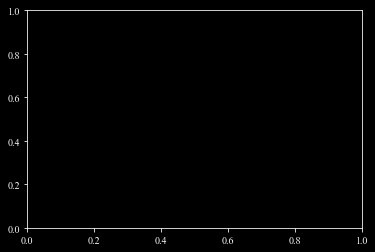

In [60]:
plt.hist(elerun)

<ipython-input-47-eb7985296948>:9: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xxt, yyt = transform(inproj, outproj, lathike, lonhike)


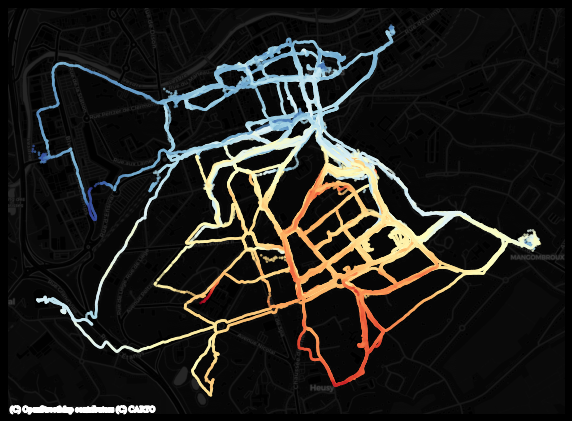

In [47]:
fig = plt.figure(figsize=(10, 10))
proj = ccrs.epsg(3857)
ax = plt.axes(projection=proj)

#ax.fill(xverviers, yverviers, edgecolor="k", color="g", linewidth=2, alpha=.15)

outproj = 'epsg:3857'
inproj = 'epsg:4326'
xxt, yyt = transform(inproj, outproj, lathike, lonhike)
plt.scatter(xxt, yyt, s=3, c=elehile, cmap=plt.cm.RdYlBu_r, alpha=.6)

if basemap is not None:
    ctx.add_basemap(ax, source=basemapdark, origin='upper', zoom=15)

ax.set_xticks([])
ax.set_yticks([])

plt.savefig(os.path.join(figdir, "verviers2020_10.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()